# Main results
Here in the coming sections we will go through the main results which group 67 found while working on project 4: Velocity estimation from Doppler radar. The goal is simple, we want to beat the baseline model in test prediction RMSE while adhering to the following modelling constraint: We are not allowed to add model complexity (#parameters)

### Helper functions

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import log10
from scipy import stats
from pathlib import Path
import torch
from torch import nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import json
import wandb

from custom_transforms import LoadSpectrogram, NormalizeSpectrogram, ToTensor, InterpolateSpectrogram
from data_management import make_dataset_name
from models import SpectrVelCNNRegr, SpectrVelCNNRegr_w_dropout, Simple_SpectrVelCNNRegr, weights_init_uniform_rule
from check_model_complexity import print_model_complexity
from plot_observation import plot_simple_spectrogram, plot_spectrogram_with_annotations


def load_single_spectrogram(file_path: str, transform) -> torch.Tensor:
    """
    Load and transform a single spectrogram for inference.
    
    Args:
        file_path (str): Path to the spectrogram file.
        transform (callable): Transform function to apply to the spectrogram.
        
    Returns:
        torch.Tensor: Transformed spectrogram ready for model inference.
    """
    # Load the spectrogram as a numpy array
    spectrogram = np.load(file_path)

    # Apply the transformations to the spectrogram
    spectrogram_tensor = transform(spectrogram)
    
    # Add batch dimension if necessary
    spectrogram_tensor = spectrogram_tensor.unsqueeze(0)  # shape: [1, C, H, W] for single sample
    
    return spectrogram_tensor

def run_inference(obs_no: int, MODEL_PATH: Path, model: nn.Module, DEVICE: str = "cpu", obs_type: str = "train") -> float:
    """
    Run inference on a given observation using a specified model.

    Args:
        obs_no (int): Observation number to load the spectrogram.
        MODEL_PATH (Path): Path to the trained model.
        model (nn.Module): The model to use for inference.
        DEVICE (str, optional): Device to run inference on (default is "cpu").

    Returns:
        float: Predicted radial velocity (vr).
    """
    # Define the transform for inference (use the same transformations as for training)
    infer_transform = transforms.Compose(
        [NormalizeSpectrogram(),
         ToTensor(),
         InterpolateSpectrogram()]
    )

    # Load the single spectrogram
    file_path = f"/dtu-compute/02456-p4-e24/data/data_fft-512_tscropwidth-150-200_vrcropwidth-60-15/{obs_type}/{obs_no}_stacked_spectrograms.npy"
    spectrogram_tensor = load_single_spectrogram(file_path, infer_transform)

    # Move the tensor to the correct device
    spectrogram_tensor = spectrogram_tensor.to(DEVICE)

    # Load the model state dictionary with map_location set to the correct device
    model.load_state_dict(torch.load(MODEL_PATH, weights_only= False, map_location=torch.device(DEVICE)))
    model.to(DEVICE)
    model.eval()

    # Load target vr for validation (optional step for reference)
    targets = pd.read_csv("/dtu-compute/02456-p4-e24/data/stmf_data_3.csv")
    target_vr = targets.BallVr.iloc[obs_no]
    
    # Run inference and return the predicted vr
    with torch.no_grad():
        predicted_vr = model(spectrogram_tensor)
    
    return predicted_vr.item()

def extract_data(log_file_path):
    """
    Extracts data from the log file for epochs, batches, batch losses,
    training losses, and test losses.
    
    Parameters:
        log_file_path (str): Path to the log file.
    
    Returns:
        batch_df (pd.DataFrame): DataFrame containing batch losses with their epochs and batches.
        epoch_df (pd.DataFrame): DataFrame containing train and test losses for each epoch.
    """
    # Initialize lists to store extracted data
    epochs = []
    batches = []
    batch_losses = []
    train_losses = []
    test_losses = []

    with open(log_file_path, "r") as file:
        for line in file:
            # Match EPOCH lines to extract the epoch number
            epoch_match = re.match(r"EPOCH (\d+):", line)
            if epoch_match:
                current_epoch = int(epoch_match.group(1))
            
            # Match batch loss lines to extract batch number and loss
            batch_match = re.match(r"\s+batch (\d+) loss: ([\d.]+)", line)
            if batch_match:
                batch_num = int(batch_match.group(1))
                loss = float(batch_match.group(2))
                # Append each batch data with the current epoch number
                epochs.append(current_epoch)
                batches.append(batch_num)
                batch_losses.append(loss)
            
            # Match the final train and test loss per epoch
            train_loss_match = re.match(r"LOSS train ([\d.]+) ; LOSS test ([\d.]+)", line)
            if train_loss_match:
                train_losses.append(float(train_loss_match.group(1)))
                test_losses.append(float(train_loss_match.group(2)))

    # Create DataFrame for batch losses
    batch_df = pd.DataFrame({
        "Epoch": epochs,
        "Batch": batches,
        "Batch Loss": batch_losses
    })

    # Create DataFrame for epoch-wise train and test losses
    epoch_df = pd.DataFrame({
        "epoch": range(1, len(train_losses) + 1),
        "train_loss": train_losses,
        "test_loss": test_losses
    })

    return batch_df, epoch_df


def plot_losses(epoch_df, run_name, run_name_title='Baseline'):
    """
    Plots training and test losses across epochs.

    Parameters:
        epoch_df (pd.DataFrame): DataFrame containing epoch, train_loss, and test_loss.
        run_name (str): Name of the run for labeling the plot.
    """
    # Identify the minimum test loss and its corresponding epoch
    min_test_loss = epoch_df['test_loss'].min()
    min_test_loss_rmse = np.sqrt(min_test_loss)  # Calculate RMSE of the minimum test loss
    min_test_loss_epoch = epoch_df[epoch_df['test_loss'] == min_test_loss]['epoch'].iloc[0]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(epoch_df['epoch'], epoch_df['train_loss'], label='Training Loss', color='blue')
    plt.plot(epoch_df['epoch'], epoch_df['test_loss'], label='Test Loss', color='orange')
    plt.scatter(min_test_loss_epoch, min_test_loss, color='red', marker='x', s=100, 
                label=f'Min Test Loss (RMSE: {min_test_loss_rmse:.2f})')

    # Customizing the plot
    plt.xscale('linear')
    plt.yscale('log')  # Log scale for the y-axis
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.title(f'Loss Curve for {run_name_title}')
    plt.legend(loc='upper right')
    plt.grid(True, which="both", ls="--", linewidth=0.5)

    # Show the figure
    plt.show()

def perform_paired_ttest(test_loss_r1, test_loss_r2):
    """
    Perform a paired t-test between two sets of test losses and interpret the results.

    Parameters:
        test_loss_r1 (list or array-like): Test losses from the first model/run.
        test_loss_r2 (list or array-like): Test losses from the second model/run.

    Returns:
        dict: A dictionary containing the t-statistic, p-value, and a string interpretation of the result.
    """
    # Perform paired t-test
    t_stat, p_value = stats.ttest_rel(test_loss_r1, test_loss_r2)

    # Interpretation
    significance = "statistically significant" if p_value < 0.05 else "not statistically significant"
    
    # Print results
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")
    print(f"The difference in test losses between the two runs is {significance}.")

    # Return results as a dictionary
    return {
        "t_statistic": t_stat,
        "p_value": p_value,
        "significance": significance
    }

def perform_wilcoxon_test(test_loss_r1, test_loss_r2):
    """
    Perform a Wilcoxon signed-rank test between two sets of test losses and interpret the results.

    Parameters:
        test_loss_r1 (list or array-like): Test losses from the first model/run.
        test_loss_r2 (list or array-like): Test losses from the second model/run.

    Returns:
        dict: A dictionary containing the test statistic, p-value, and a string interpretation of the result.
    """
    # Perform Wilcoxon signed-rank test
    wilcoxon_stat, p_value = stats.wilcoxon(test_loss_r1, test_loss_r2)

    # Interpretation
    significance = "statistically significant" if p_value < 0.05 else "not statistically significant"

    # Print results
    print(f"Wilcoxon test statistic: {wilcoxon_stat}")
    print(f"P-value: {p_value}")
    print(f"The difference in test losses between the two runs is {significance}.")

    # Return results as a dictionary
    return {
        "wilcoxon_statistic": wilcoxon_stat,
        "p_value": p_value,
        "significance": significance
    }

## The dataset

The dataset consists of spectrogram data and associated target radial velocity values for training and evaluation. It includes the following main components:

1. Spectrogram Data
- **Observation Types**: The dataset contains **stacked spectrograms** with **6 channels** per observation.
- **Channels**:
  - **Channels 1–4**: Represent **power spectrograms**, capturing the intensity of signal frequencies over time.
  - **Channels 5–6**: Represent **phase spectrograms**, detailing the phase information of the signal.
- **Observations**:
  - **Training set**: 1,239 observations.
  - **Test set**: 743 observations.
  - **Validation set**: 83 observations.

2. Target Data
- **Radial Velocity Values**:
  - **258,368 valid radial velocity values** are available.
  - **45,529 null (missing) radial velocity values** are present, indicating incomplete data or observations where the target was not measurable.

In [35]:
# Path to the dataset JSON file
dataset_json_path = '/dtu-compute/02456-p4-e24/data/data_fft-512_tscropwidth-150-200_vrcropwidth-60-15/dataset.json' 

# Load and read the JSON data
with open(dataset_json_path, 'r') as f:
    dataset_info = json.load(f)

# Count the number of observations in each split
train_count = len(dataset_info.get('train', []))
test_count = len(dataset_info.get('test', []))
validation_count = len(dataset_info.get('validation', []))

print(dataset_info.get('test', []))

# Print out the number of observations for each split
print(f"Train dataset observations: {train_count}")
print(f"Test dataset observations: {test_count}")
print(f"Validation dataset observations: {validation_count}")

targets = pd.read_csv("/dtu-compute/02456-p4-e24/data/stmf_data_3.csv")

# Print the number of non-null target radial velocity values
valid_target_count = targets['BallVr'].notnull().sum()
print(f"Number of valid target radial velocity values: {valid_target_count}")

# Print how many values are null
null_target_count = targets['BallVr'].isnull().sum()
print(f"Number of null target radial velocity values: {null_target_count}")



[240359, 240474, 240155, 241088, 240840, 137012, 240251, 240837, 148130, 240548, 241512, 240266, 137037, 241164, 240843, 240191, 241139, 240416, 240313, 240137, 147910, 148188, 240808, 136310, 147787, 138710, 136957, 240197, 241117, 241363, 147748, 240151, 138949, 148174, 136923, 240683, 148190, 241220, 240384, 138775, 148228, 240823, 239996, 148232, 240028, 137481, 240447, 241029, 147945, 241227, 239981, 240507, 148155, 240135, 137320, 241255, 148062, 147878, 240794, 241041, 240529, 240265, 240830, 148169, 138583, 241374, 138265, 138037, 240886, 148053, 241006, 136178, 138937, 137017, 240662, 241443, 240512, 147904, 136999, 240914, 147978, 241310, 241298, 241026, 137484, 241027, 137349, 241217, 136401, 147832, 137441, 136891, 147794, 138388, 240165, 241193, 240192, 240797, 147886, 147938, 147716, 148085, 240410, 138874, 148058, 240224, 147901, 240741, 240784, 241064, 137984, 241245, 147956, 241527, 241458, 136216, 137236, 148025, 147806, 240354, 139039, 136962, 240007, 240870, 241513,

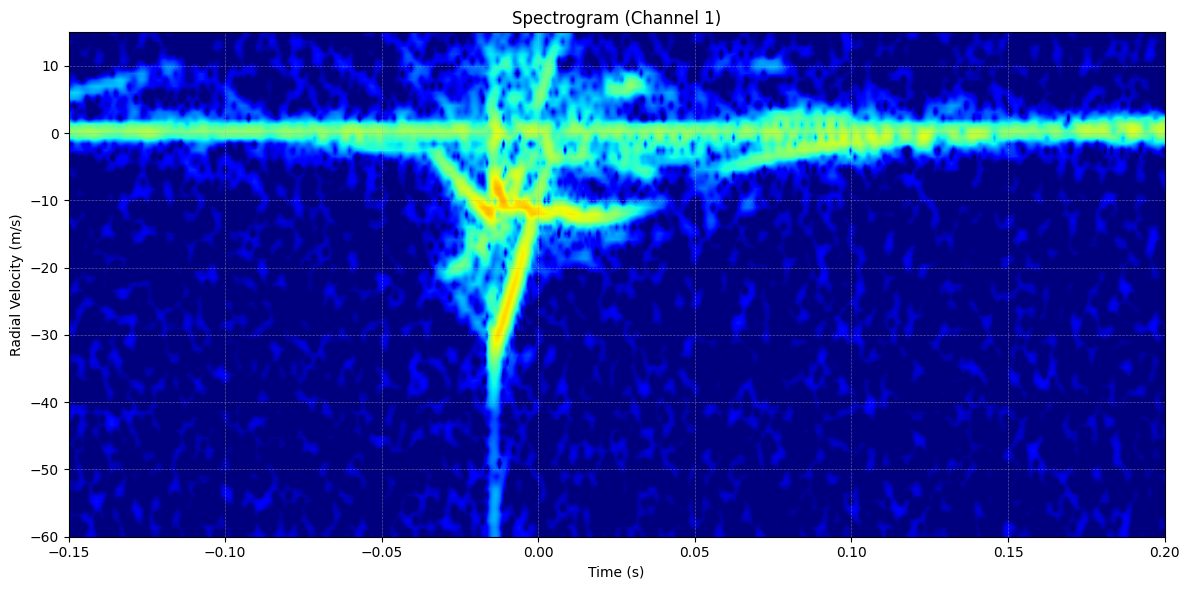

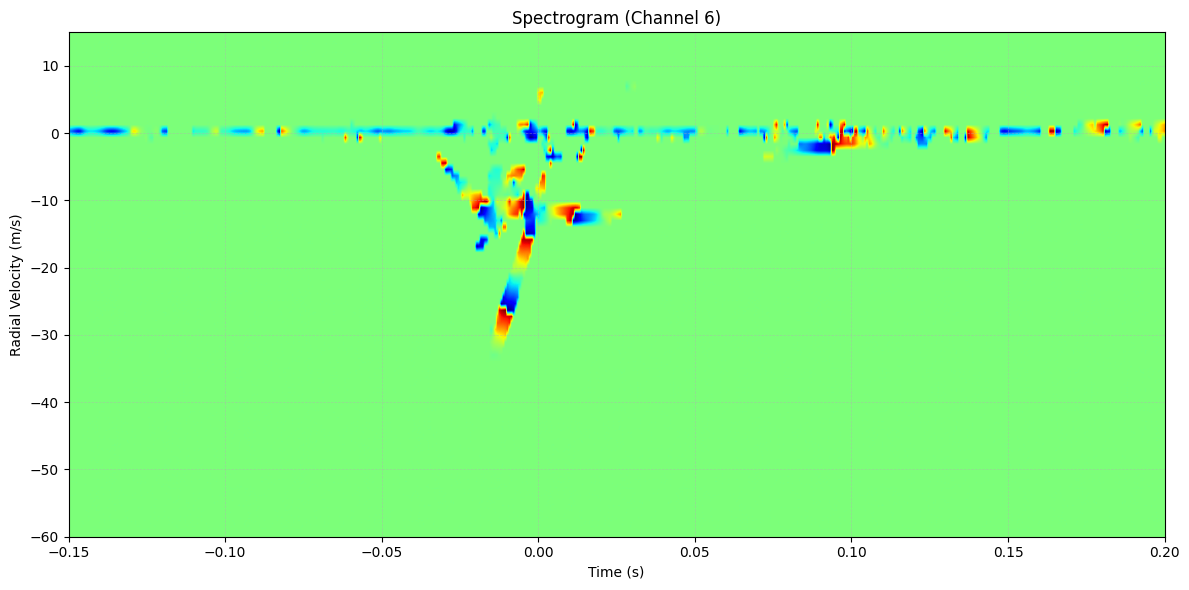

In [ ]:
# Looking into spectograms of a random training observation
obs_no = 137026 
file_path = f"/dtu-compute/02456-p4-e24/data/data_fft-512_tscropwidth-150-200_vrcropwidth-60-15/train/{obs_no}_stacked_spectrograms.npy"
plot_simple_spectrogram(file_path, spectrogram_channel=0) # Channesl 1-4 are power spectrograms
plot_simple_spectrogram(file_path, spectrogram_channel=5) # Channels 5-6 are phase spectrograms

## The Baseline Model

### Model architecture and complexity
 We start with looking at the model architecture of the baseline model, called **SpectrVelCNNRegr**, and then check the model complexity, that is the total number of parameters in the model. We then train it just to show the basic process, but only on 2 epochs as it takes around 300 epochs and 50 minutes to run it until it converges, which we did using the HPC cluster via batch jobs.

The SpectrVelCNNRegr model consists of four convolutional layers that progressively increase in depth, enabling it to first extract basic low-level features and then capture higher-level, abstract patterns in the deeper layers. After flattening the feature maps, the model uses two fully connected layers to learn complex relationships between these features, ultimately outputting a single value: the radial velocity. We also output the model settings which are learning rate = 1e-5, batch size = 10 and optimizer = SGD. Finally we look at the model complexity which is quite high, as the number of parameters is 38,414,929.

In [17]:
model = SpectrVelCNNRegr
learning_rate = 10**-5
batch_size = 10
optimizer = torch.optim.SGD

print(model())

# Print additional settings
print("\nModel Settings:")
print(f"Learning Rate: {learning_rate}")
print(f"Batch Size: {batch_size}")
print(f"Optimizer: {optimizer.__name__} \n")

print_model_complexity(model)
print("")


SpectrVelCNNRegr(
  (conv1): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=37120, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=256, bia

In [ ]:
# GROUP NUMBER
GROUP_NUMBER = 67

# CONSTANTS TO MODIFY AS YOU WISH
MODEL = SpectrVelCNNRegr
LEARNING_RATE = 10**-5
EPOCHS = 2 # the model converges in test perfermance after ~250-300 epochs
BATCH_SIZE = 10
NUM_WORKERS = 4
OPTIMIZER = torch.optim.SGD

DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
#DEVICE = "cuda"

# You can set the model path name in case you want to keep training it.
# During the training/testing loop, the model state is saved
# (only the best model so far is saved)
LOAD_MODEL_FNAME = None
# LOAD_MODEL_FNAME = f"model_{MODEL.__name__}_bright-candle-20"

# CONSTANTS TO LEAVE
DATA_ROOT = Path(f"/dtu-compute/02456-p4-e24/data") 
#ROOT = Path(__file__).parent.parent
ROOT = Path().resolve().parent

MODEL_DIR = ROOT / "models"
STMF_FILENAME = "stmf_data_3.csv"
NFFT = 512
TS_CROPTWIDTH = (-150, 200)
VR_CROPTWIDTH = (-60, 15)


def train_one_epoch(loss_fn, model, train_data_loader):
    running_loss = 0.
    last_loss = 0.
    total_loss = 0.

    for i, data in enumerate(train_data_loader):
        spectrogram, target = data["spectrogram"].to(DEVICE), data["target"].to(DEVICE)

        optimizer.zero_grad()

        outputs = model(spectrogram)

        # Compute the loss and its gradients
        loss = loss_fn(outputs.squeeze(), target)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        total_loss += loss.item()
        if i % train_data_loader.batch_size == train_data_loader.batch_size - 1:
            last_loss = running_loss / train_data_loader.batch_size # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return total_loss / (i+1)

if __name__ == "__main__":
    print(f"Using {DEVICE} device")

    # DATA SET SETUP
    dataset_name = make_dataset_name(nfft=NFFT, ts_crop_width=TS_CROPTWIDTH, vr_crop_width=VR_CROPTWIDTH)
    data_dir = DATA_ROOT / dataset_name

    TRAIN_TRANSFORM = transforms.Compose(
        [LoadSpectrogram(root_dir=data_dir / "train"),
        NormalizeSpectrogram(),
        ToTensor(),
        InterpolateSpectrogram()]
    )
    TEST_TRANSFORM = transforms.Compose(
        [LoadSpectrogram(root_dir=data_dir / "test"),
        NormalizeSpectrogram(),
        ToTensor(),
        InterpolateSpectrogram()]
    )
    dataset_train = MODEL.dataset(data_dir= data_dir / "train",
                           stmf_data_path = DATA_ROOT / STMF_FILENAME,
                           transform=TRAIN_TRANSFORM)

    dataset_test = MODEL.dataset(data_dir= data_dir / "test",
                           stmf_data_path = DATA_ROOT / STMF_FILENAME,
                           transform=TEST_TRANSFORM)
    
    train_data_loader = DataLoader(dataset_train, 
                                   batch_size=BATCH_SIZE,
                                   shuffle=True,
                                   num_workers=NUM_WORKERS)
    test_data_loader = DataLoader(dataset_test,
                                  batch_size=500,
                                  shuffle=False,
                                  num_workers=1)
    
    # If you want to keep training a previous model
    if LOAD_MODEL_FNAME is not None:
        model = MODEL().to(DEVICE)
        model.load_state_dict(torch.load(MODEL_DIR / LOAD_MODEL_FNAME))
        model.eval()
    else:
        model = MODEL().to(DEVICE)
        model.apply(weights_init_uniform_rule)

    optimizer = OPTIMIZER(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    
    # Set up wandb for reporting
    wandb.init(
        project=f"02456_group_{GROUP_NUMBER}",
        config={
            "learning_rate": LEARNING_RATE,
            "architecture": MODEL.__name__,
            "dataset": MODEL.dataset.__name__,
            "epochs": EPOCHS,
            "batch_size": BATCH_SIZE,
            "transform": "|".join([str(tr).split(".")[1].split(" ")[0] for tr in dataset_train.transform.transforms]),
            "optimizer": OPTIMIZER.__name__,
            "loss_fn": model.loss_fn.__name__,
            "nfft": NFFT
        }
    )

    # Define model output to save weights during training
    MODEL_DIR.mkdir(exist_ok=True)
    model_name = f"model_{MODEL.__name__}_{wandb.run.name}"
    model_path = MODEL_DIR / model_name


    ## TRAINING LOOP
    epoch_number = 0
    best_vloss = 1_000_000.

    # import pdb; pdb.set_trace()

    for epoch in range(EPOCHS):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on
        model.train(True)

        # Do a pass over the training data and get the average training MSE loss
        avg_loss = train_one_epoch(MODEL.loss_fn, model, train_data_loader)
        
        # Calculate the root mean squared error: This gives
        # us the opportunity to evaluate the loss as an error
        # in natural units of the ball velocity (m/s)
        rmse = avg_loss**(1/2)

        # Take the log as well for easier tracking of the
        # development of the loss.
        log_rmse = log10(rmse)

        # Reset test loss
        running_test_loss = 0.

        # Set the model to evaluation mode
        model.eval()

        # Disable gradient computation and evaluate the test data
        with torch.no_grad():
            for i, vdata in enumerate(test_data_loader):
                # Get data and targets
                spectrogram, target = vdata["spectrogram"].to(DEVICE), vdata["target"].to(DEVICE)
                
                # Get model outputs
                test_outputs = model(spectrogram)

                # Calculate the loss
                test_loss = MODEL.loss_fn(test_outputs.squeeze(), target)

                # Add loss to runnings loss
                running_test_loss += test_loss

        # Calculate average test loss
        avg_test_loss = running_test_loss / (i + 1)

        # Calculate the RSE for the training predictions
        test_rmse = avg_test_loss**(1/2)

        # Take the log as well for visualisation
        log_test_rmse = torch.log10(test_rmse)

        print('LOSS train {} ; LOSS test {}'.format(avg_loss, avg_test_loss))
        
        # log metrics to wandb
        wandb.log({
            "loss": avg_loss,
            "rmse": rmse,
            "log_rmse": log_rmse,
            "test_loss": avg_test_loss,
            "test_rmse": test_rmse,
            "log_test_rmse": log_test_rmse,
        })

        # Track best performance, and save the model's state
        if avg_test_loss < best_vloss:
            best_vloss = avg_test_loss
            torch.save(model.state_dict(), model_path)

        epoch_number += 1

    wandb.finish()

Using cpu device


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: s232411 (s232411-danmarks-tekniske-universitet-dtu). Use `wandb login --relogin` to force relogin


EPOCH 1:
  batch 10 loss: 997.4306518554688
  batch 20 loss: 939.7878601074219
  batch 30 loss: 906.7645385742187
  batch 40 loss: 517.7327171325684
  batch 50 loss: 237.40815048217775
  batch 60 loss: 87.96615524291992
  batch 70 loss: 84.53458976745605
  batch 80 loss: 118.86949234008789
  batch 90 loss: 102.42445831298828
  batch 100 loss: 89.10928754806518
  batch 110 loss: 119.21473770141601
  batch 120 loss: 114.57502326965331
LOSS train 350.91921461013055 ; LOSS test 81.15191650390625
EPOCH 2:
  batch 10 loss: 76.88008728027344
  batch 20 loss: 97.34405612945557
  batch 30 loss: 109.92061347961426
  batch 40 loss: 89.41721954345704
  batch 50 loss: 67.81328191757203
  batch 60 loss: 59.40260276794434
  batch 70 loss: 116.49842224121093
  batch 80 loss: 72.00712623596192
  batch 90 loss: 87.76093463897705
  batch 100 loss: 46.71684951782227
  batch 110 loss: 67.51919975280762
  batch 120 loss: 59.673579692840576
LOSS train 79.56980162282144 ; LOSS test 70.58086395263672


log_rmse,█▁
log_test_rmse,█▁
loss,█▁
rmse,█▁
test_loss,█▁
test_rmse,█▁
log_rmse,0.95037
log_test_rmse,0.92434
loss,79.5698
rmse,8.92019
test_loss,70.58086


To visualize the training process, we plotted the loss curves for both the training and test data, using a log scale to highlight the changes more effectively. We can clearly see the model is overfitting as the training loss consistently decreases but the test loss plateaus early, failing to improve after a certain point. This was a strong suggestion that a good start was to add some regularization.

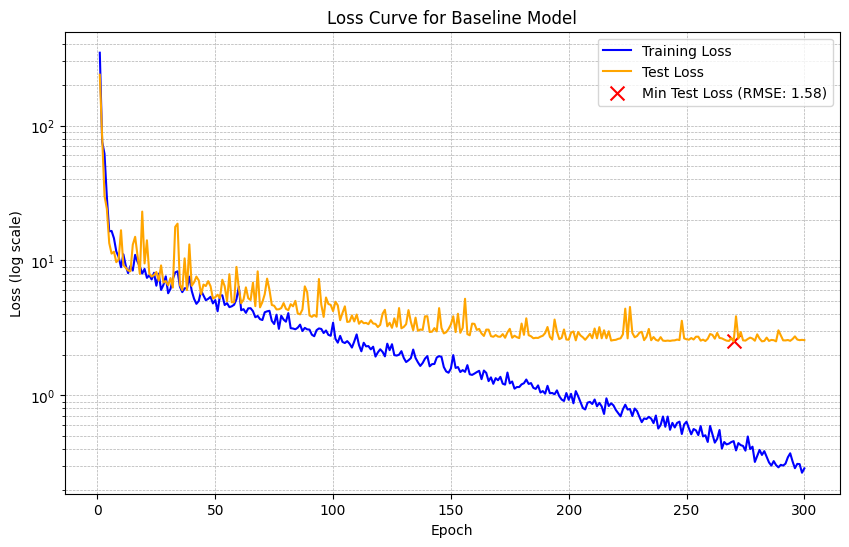

In [21]:
# Baseline run:
run_name = 'baseline_run'
log_file_path = f"/zhome/52/6/202465/02456_grp_67_project_4/wandb/{run_name}/files/output.log"

# Extract data
batch_df, epoch_df = extract_data(log_file_path)

# Plot data
plot_losses(epoch_df, run_name, run_name_title='Baseline Model')

To compare the target radial velocity against the estimate from our model we plotted them on to our spectrogram plots, for some random train and test observations.

Target radial velocity for training observation 137026: -36.68436694
Predicted radial velocity for training observation 137026: -35.7624397277832


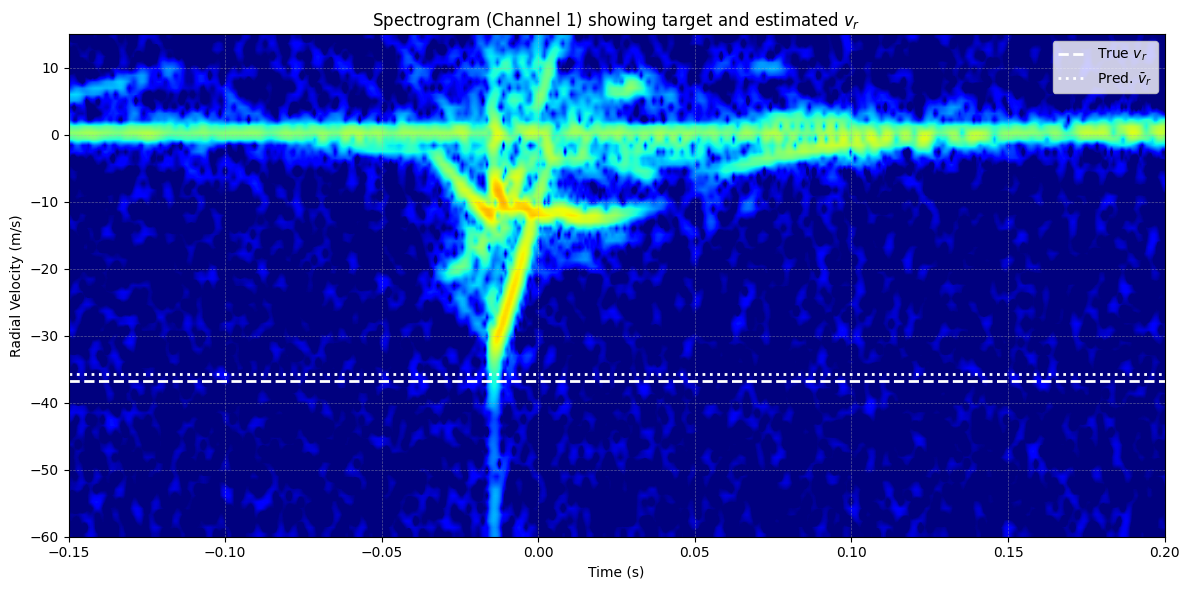

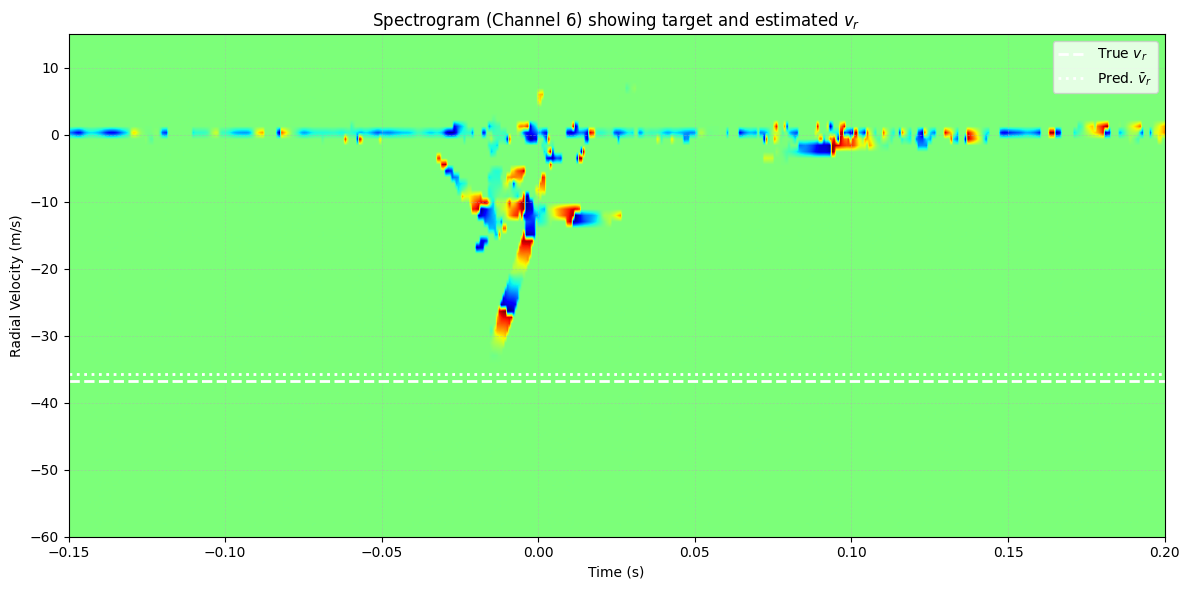

Target radial velocity for test observation 240840: -42.86758627
Predicted radial velocity for test observation 240840: -47.312339782714844


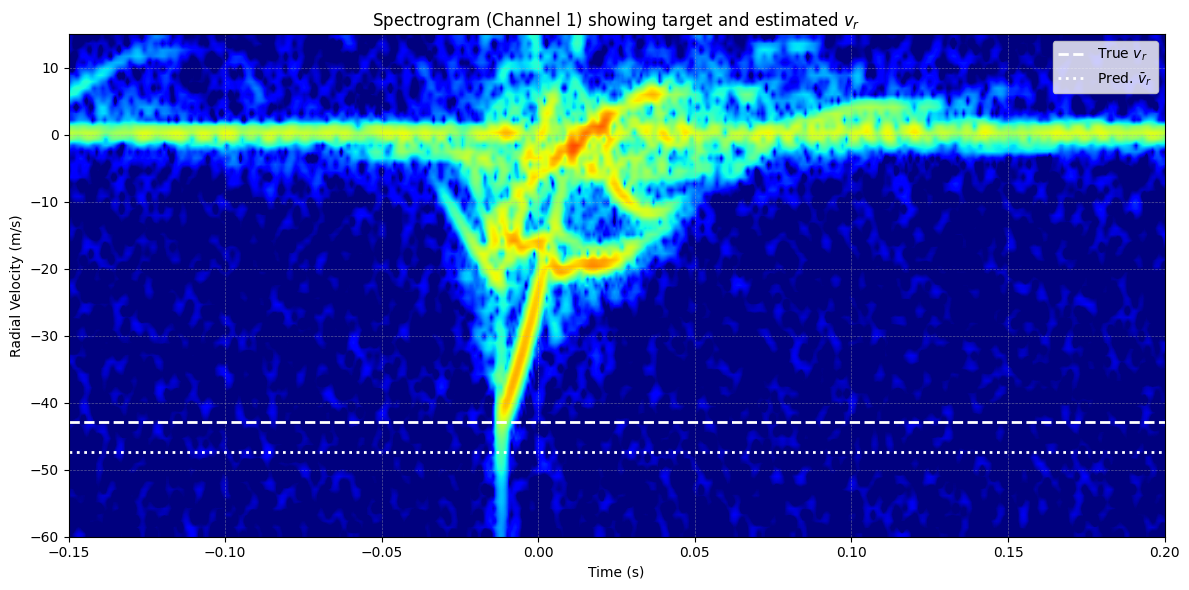

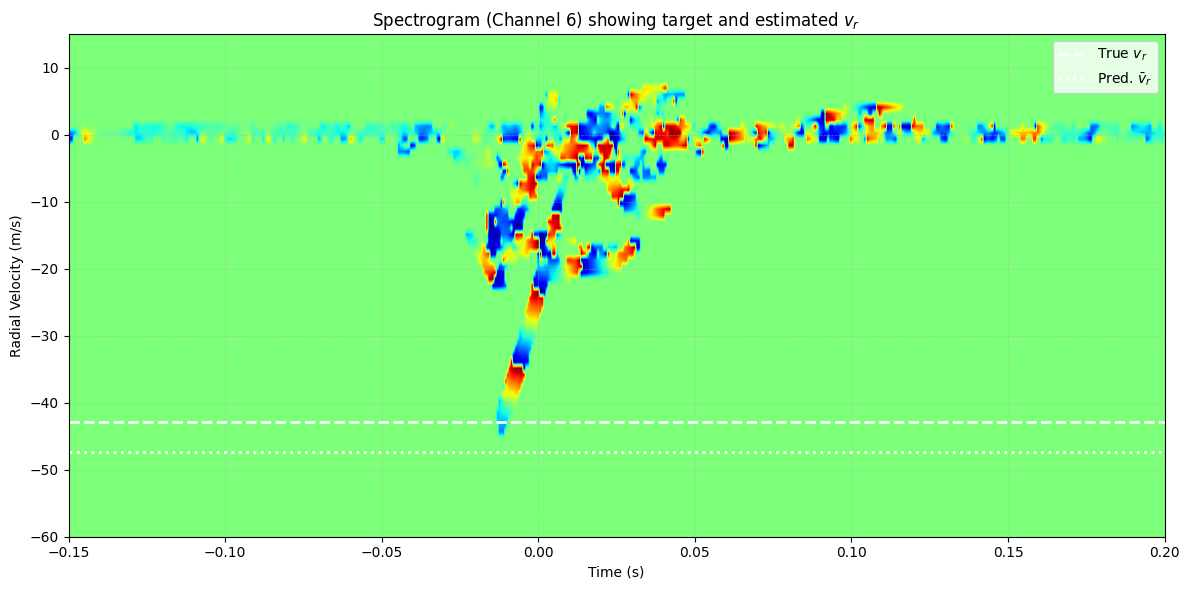

In [45]:
obs_no = 137026

MODEL_PATH = Path("/zhome/52/6/202465/02456_grp_67_project_4/models/model_SpectrVelCNNRegr_cerulean-galaxy-68")
model = SpectrVelCNNRegr()  # Replace with your actual model class
DEVICE = "cpu"  # Or "cuda" if using a GPU

targets = pd.read_csv("/dtu-compute/02456-p4-e24/data/stmf_data_3.csv")
target_vr = targets.BallVr.iloc[obs_no]

predicted_vr = run_inference(obs_no, MODEL_PATH, model, DEVICE, obs_type='train')
print(f"Target radial velocity for training observation {obs_no}: {target_vr}")
print(f"Predicted radial velocity for training observation {obs_no}: {predicted_vr}")

file_path = f"/dtu-compute/02456-p4-e24/data/data_fft-512_tscropwidth-150-200_vrcropwidth-60-15/train/{obs_no}_stacked_spectrograms.npy"
plot_spectrogram_with_annotations(file_path, target_vr=target_vr, estimated_vr=predicted_vr, spectrogram_channel=0)
plot_spectrogram_with_annotations(file_path, target_vr=target_vr, estimated_vr=predicted_vr, spectrogram_channel=5)

####

test_obs_no = 240840

test_target_vr = targets.BallVr.iloc[test_obs_no]

predicted_test_vr = run_inference(test_obs_no, MODEL_PATH, model, DEVICE, obs_type='test')
print(f"Target radial velocity for test observation {test_obs_no}: {test_target_vr}")
print(f"Predicted radial velocity for test observation {test_obs_no}: {predicted_test_vr}")

file_path = f"/dtu-compute/02456-p4-e24/data/data_fft-512_tscropwidth-150-200_vrcropwidth-60-15/test/{test_obs_no}_stacked_spectrograms.npy"
plot_spectrogram_with_annotations(file_path, target_vr=test_target_vr, estimated_vr=predicted_test_vr, spectrogram_channel=0)
plot_spectrogram_with_annotations(file_path, target_vr=test_target_vr, estimated_vr=predicted_test_vr, spectrogram_channel=5)

## Improvements of the Baseline Model
As mentioned above, we saw the need for adding in some regularization to enable the baseline model to perform better (be more general) against unseen data. But what we started out with was changing the optimizer from the SGD (Stochastic Gradient Descent) to the Adam optimizer, which often performs quite well. With that being the only change the models test RMSE went from 1.58 m/s to 1.

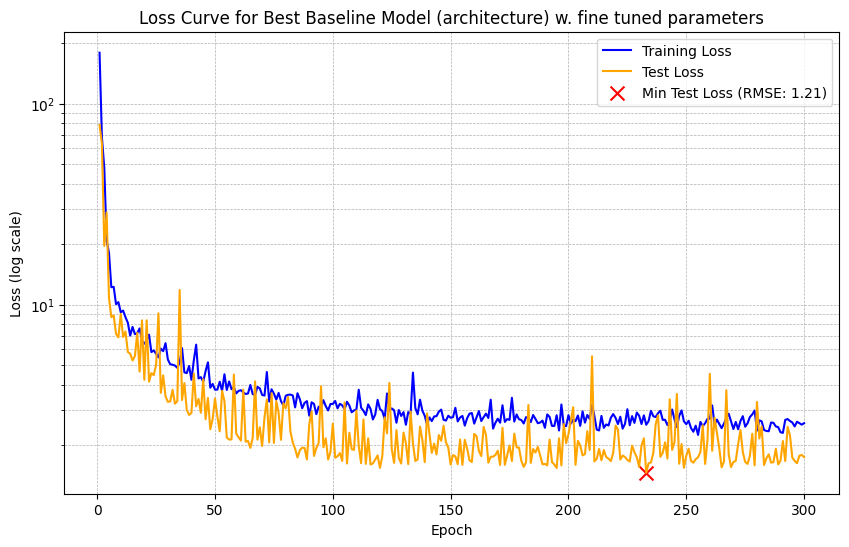

In [6]:
# Best 'less complex model' run:
run_name = 'adam_b16_dropout30'
log_file_path = f"/zhome/52/6/202465/02456_grp_67_project_4/wandb/{run_name}/files/output.log"

# Extract data
batch_df, epoch_df = extract_data(log_file_path)

# Plot data
plot_losses(epoch_df, run_name, 'Best Baseline Model (architecture) w. fine tuned parameters')

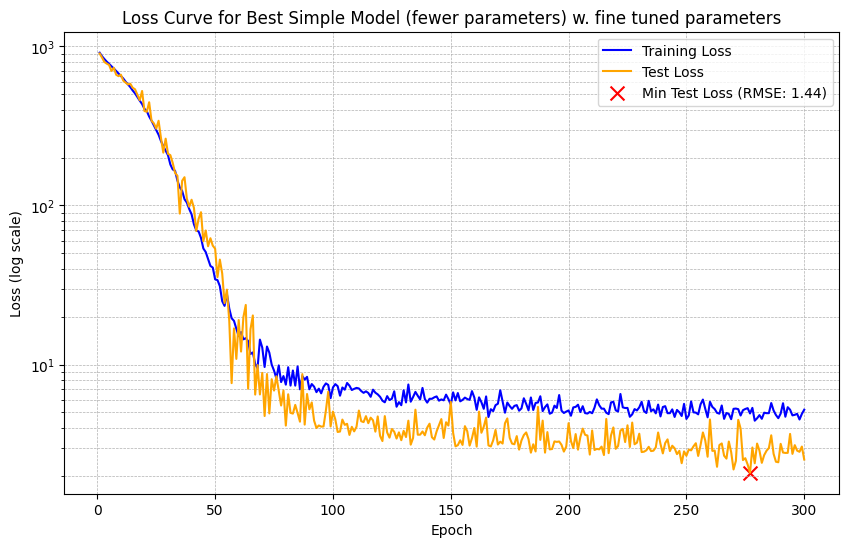

In [7]:
# Best 'less complex model' run:
run_name = 'less_complex_weight_decay_1e-6'
log_file_path = f"/zhome/52/6/202465/02456_grp_67_project_4/wandb/{run_name}/files/output.log"

# Extract data
batch_df, epoch_df = extract_data(log_file_path)

# Plot data
plot_losses(epoch_df, run_name, 'Best Simple Model (fewer parameters) w. fine tuned parameters')

## Statistical tests to compare the performance between two different models
Here we perform a statistical paired t-test where we compare the loss output of two different models, the baseline model and then one of our improved models, to see if there is a statistical difference between the two models. Since the paired t-test assumes the difference between the two loss outputs has a normal distribution we also included a Wilcoxon signed-rank test which does not have that strong assumptions about the samples (the loss data).

In [ ]:
# Example file paths for two runs
log_file_run1 = "/zhome/52/6/202465/02456_grp_67_project_4/wandb/baseline_vol3/files/output.log"
log_file_run2 = "/zhome/52/6/202465/02456_grp_67_project_4/wandb/adam_b16_dropout30/files/output.log"

# Extract test losses from both runs
_, epoch_df = extract_data(log_file_run1)
test_loss_r1 = list(epoch_df['test_loss'])

_, epoch_df = extract_data(log_file_run2)
test_loss_r2 = list(epoch_df['test_loss'])

# Perform the t-test
t_test = perform_paired_ttest(test_loss_r1, test_loss_r2)

print('')

# Perform the Wilcoxon signed-rank test
wilcoxon_test = perform_wilcoxon_test(test_loss_r1, test_loss_r2)

T-statistic: -1.2537996362082977
P-value: 0.2108942484379315
The difference in test losses between the two runs is not statistically significant.

Wilcoxon test statistic: 14856.0
P-value: 2.849040838370308e-07
The difference in test losses between the two runs is statistically significant.
